### CAN Model Loop with Skill Score calculation

File created on 6/17/2025 for the controlled abstention model. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
import random
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import TimeSeriesSplit
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

#tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-18 22:04:25.001954: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 22:04:25.033813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 22:04:25.033835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 22:04:25.034799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 22:04:25.039931: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from StatScores import BSS
from StatScores import RAS_two
from StatScores import PAS_two

##This cell includes the new class and def functions from Barnes and Barnes 2021 relevant for creating a CAN. 
import metrics
import abstentionloss

### Inputs.

In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
# load input solvers
infile = open("../../reduced_data/PCs/U_14.p","rb",)
U_PC = pickle.load(infile)  ##pv on an isentropic surface, 350
infile.close()

infile = open("../../reduced_data/PCs/EHF_14.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../reduced_data/PCs/GPH_14.p","rb",)
GPH_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

##remove PC 1
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

U_PC.shape

(9238, 9)

In [5]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=1) 

##make pandas dataframe for RF
input = pd.DataFrame(inputvar)
#input

In [6]:
#selected indices
#EUROPE
#input[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]

##CANADA
#input[[56, 1, 0, 55, 2, 53, 22, 57, 9, 25, 11, 4, 54, 38, 17, 30, 36, 3, 14, 26]]

##SE US
#input[[56, 1, 54, 18, 53, 3, 0, 10, 5, 19, 21, 14, 2, 57, 13, 60, 22, 26,25, 11]]

In [7]:
#create pd datafram of selected feature columns.
sele_ind_df = input[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]

n_features = 20

In [8]:
#turn input array into (# samples, 14 days, 10 features)
sele_ind_data = sele_ind_df.values
sele_ind_data1 = sele_ind_data.reshape(62,149,n_features)

In [9]:
sele_ind_data.shape

(9238, 20)

### Outputs. 

In [10]:
# load output data
infile = open("../../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
infile.close()

output.shape

(9238,)

In [11]:
# load climo data
infile = open("../../reduced_data/climo/eur_climo14.p","rb",)
climo = pickle.load(infile) 
infile.close()

In [12]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]

climo = climo.reshape(62, 149,2)
climo = climo[:, 14:, :]
#climo = climo.reshape(8370,2)

print("input: ",sele_ind_data1.shape)
print("climo: ",climo.shape)
print("output: ",temp.shape)

input:  (62, 149, 20)
climo:  (62, 135, 2)
output:  (62, 135)


In [13]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,lead,14,n_features))
new_output = np.empty((62,lead))
new_climo = np.empty((62,lead,2))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = sele_ind_data1[i,j:j+14,:]
        new_output[i,j] = temp[i,j]
        new_climo[i,j] = climo[i,j,:]

In [14]:
new_input = np.array(new_input)
new_climo = np.array(new_climo.reshape(62*lead,2))
new_output = np.array(new_output)

print("input: ",new_input.shape)
print("climo: ",new_climo.shape)
print("output: ",new_output.shape)

input:  (62, 135, 14, 20)
climo:  (8370, 2)
output:  (62, 135)


In [15]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)

print("testing and validation size: ",frac_ind)
print("training size: ",frac_end)

testing and validation size:  1256
training size:  7114


In [16]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*lead),14,n_features))
Y_all = np.copy(new_output.flatten())

print(X_all.shape)
print(Y_all.shape)

(8370, 14, 20)
(8370,)


In [17]:
##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

print("Training")
print(X_tri.shape)
print(Y_tri.shape)
print(" ")
print("Testing")
print(X_tes.shape)
print(Y_tes.shape)

Training
(7114, 14, 20)
(7114,)
 
Testing
(1256, 14, 20)
(1256,)


In [18]:
#Convert the Y array into a categorical array
#Traditionally, I have done this using keras.utils.to_categorical ... but I am going to try to use another method
#shown in the example file from Barnes and Barnes
from sklearn import preprocessing
import time

def onehot_abstent(y_all, y_train, y_test, num_cats):
    encoder = preprocessing.OneHotEncoder(categories='auto', sparse_output=False)
    encoder.fit(np.arange(num_cats).reshape(-1,1))
    
    onehotlabels_all = encoder.transform(np.array(y_all).reshape(-1, 1))
    onehotlabels_train = encoder.transform(np.array(y_train).reshape(-1, 1))
    onehotlabels_test = encoder.transform(np.array(y_test).reshape(-1, 1))
    
    onehotlabels_all = np.concatenate([onehotlabels_all, np.zeros((onehotlabels_all.shape[0], 1))], axis=1)
    onehotlabels_train = np.concatenate([onehotlabels_train, np.zeros((onehotlabels_train.shape[0], 1))], axis=1)
    onehotlabels_test = np.concatenate([onehotlabels_test, np.zeros((onehotlabels_test.shape[0], 1))], axis=1)
    
    return onehotlabels_all, onehotlabels_train, onehotlabels_test;

In [19]:
##one hot encode and add on the abstention category
Y_all, Y_tri, Y_tes = onehot_abstent(Y_all, Y_tri, Y_tes, 2)

In [20]:
print(Y_all.shape)
print(Y_tri.shape)
print(Y_tes.shape)

(8370, 3)
(7114, 3)
(1256, 3)


In [21]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(Y_tri)) or np.any(np.isinf(Y_tri)):
    print("NaN or Inf values found in Y_tri!")

if np.any(np.isnan(Y_tes)) or np.any(np.isinf(Y_tes)):
    print("NaN or Inf values found in Y_tes!")

### Begin establishing specifics of model.

In [22]:
##number of input nodes
numb_int = X_all.shape[1:]
#this defines the 2-d shape used by the lstm model.
print("shape of lstm input: ",numb_int)

shape of lstm input:  (14, 20)


In [23]:
########
#CHANGE BASED ON NUMBER OF FOLDS FOR TIMESERIES SPLIT
#repeat = 2
#split = 7
#n = repeat*split

n = 100

In [24]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

All empty lists in next three cells. 

In [25]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = [] 

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))
BSS_90= np.empty((n,))

BSS_avg= np.empty((n,))
BSS_30= np.empty((n,))
BSS_70= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))

In [26]:
##empty lists for ACC scores 
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

In [27]:
p_test = []
p_train = []
p_val = []

abs_test = np.empty((n,))
abs_train = np.empty((n,))
abs_val = np.empty((n,))

p_mid = []
p_90 = []
p_30 = []
p_70 = []

### Model Architecture. 

Start with model definition cells from Barnes and Barnes 2021. 

In [28]:
#These definition statements are from Barnes and Barnes 2021
#the "make model" cell contains the DNN for testing whether the model learns and the CAN for abstention
def make_model(ntimestep, nfeature, n1, n2, n3, rl1, rl3, lr, alpha_init, setpoint, spinup_epochs, nupd,
              loss_str = 'NotWrongLoss', updater_str = 'Colorado'):
    
    tf.keras.backend.clear_session()
    if(loss_str == 'DNN'):
        input_tensor = Input(shape=(ntimestep, nfeature))

        layer1 = layers.RNN(
            layers.LSTMCell(n1, activation='tanh', use_bias=True,
                            dropout=0.4, 
                            kernel_initializer='glorot_uniform',
                            kernel_regularizer=keras.regularizers.l2(l2=rl1)),
            return_sequences=False)(input_tensor)

        output_tensor = layers.Dense(2, activation='softmax')(layer1)

        model = Model(input_tensor, output_tensor)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

        return model, None  
    
    else:
        input_tensor = Input(shape=(ntimestep, nfeature))
    
        layer1 = layers.RNN(
            layers.LSTMCell(n1, activation='tanh', use_bias=True,
                              dropout=0.2, 
                              kernel_initializer='glorot_uniform',
                              kernel_regularizer=keras.regularizers.l2(l2= rl1)),
            return_sequences=False)(input_tensor)

        #layer2 = layers.RNN(
            #layers.LSTMCell(n2, activation='tanh', use_bias=True,
                             #kernel_initializer='glorot_uniform',
                             #kernel_regularizer=keras.regularizers.l2(l2= rl1)))(layer1)

        layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                             kernel_initializer='he_normal',bias_initializer='he_normal',
                              kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer1)
        ### change the output tensor to reflect the inclusion of the abstention category.
        output_tensor = layers.Dense(3, activation='softmax',)(layer3)

        model = Model(input_tensor, output_tensor)
        updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                       alpha_init=alpha_init, 
                                                       length=nupd)
        loss_function = getattr(abstentionloss, loss_str)(updater=updater,
                                                          spinup_epochs=spinup_epochs)
        model.compile(
            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=lr),#tf.keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[keras.metrics.categorical_accuracy,
                alpha_value,
                metrics.AbstentionFraction(abstain=2),
                metrics.PredictionLoss(abstain=2),
                metrics.PredictionAccuracy(abstain=2)
            ]
        )        
        
    # model.summary()
        
    return model, loss_function

#---------------------------------------------------
def alpha_value(y_true,y_pred):
    return loss_function.updater.alpha

#---------------------------------------------------
def scheduler(epoch, lr):
    if epoch < lr_epoch_bound:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

#---------------------------------------------------
class EarlyStoppingCAN(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingCAN, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as zero.
        self.best = 0.
        self.best_epoch = np.Inf
        # initialize best_weights to non-trained model
        self.best_weights = self.model.get_weights()
        

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_prediction_accuracy")
        if np.greater(current, self.best):
            abstention_error = np.abs(logs.get("val_abstention_fraction") - setpoint)
            if np.less(abstention_error,.1):
                self.best = current
                self.wait = 0
                # Record the best weights if current results is better (greater).
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Early stopping, setting to best_epoch = " + str(self.best_epoch + 1))    


In [29]:
## create loop for cross validation
model_fail = 0
for l in range(0,n):
    print("#######################################")
    print("CV ",l)
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 15% window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]
    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    
    ##same partitioning for climo data
    climo_train1 = new_climo[0:start,:]
    climo_train2 = new_climo[end:frac_end,:]
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##pause, calculate climo probabilities
    climo_val = new_climo[start:end,:]
    climo_test = new_climo[frac_end:,:]
    #####################################
    ##INSERT LOOP FOR CAN MODEL INITALIZATION from Barnes and Barnes 2021
    batch_size = 64 #The number of samples the network sees before it backpropagates (batch size)
    epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
    shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
    verbose = 0 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

    # Set parameters
    LOSS = 'ClassWeight_NotWrongLoss' #or DNN
    UPDATER = 'Washington'
    NLABEL = 3 #number of categories
    NUPD = 50
    SPINUP_EPOCHS = 0
    setpoint = 0.275
    alpha_init = 1
    BATCH_SIZE = batch_size
    N_EPOCHS = epochs
    #---------------------
    NETWORK_SEED = 0
    network_type = 'CAN' # 'CAN' or 'DNN'
    #---------------------


    #-------------------------------
    # Get the model
    tf.keras.backend.clear_session()
    
    # define the model, loss function and callbacks
    if(network_type=='DNN'):
        print('--> Training a DNN...')    
        model, loss_function = make_model(ntimestep = numb_int[0],
                                          nfeature = numb_int[1],
                                          n1 = 6, 
                                          rl1 = 0.077,  
                                          lr = 0.015, #0.0006466
                                          alpha_init = alpha_init,
                                          setpoint=setpoint, 
                                          spinup_epochs=SPINUP_EPOCHS,
                                          nupd=NUPD,
                                          loss_str = LOSS, 
                                          updater_str=UPDATER)
        callbacks = []

    if(network_type=='CAN'):
        print('--> Training a CAN...')    
        es_can_callback = EarlyStoppingCAN(patience=40)            
        model, loss_function = make_model(ntimestep = numb_int[0],
                                          nfeature = numb_int[1],
                                          n1 = 6,
                                          n2= 4,
                                          n3 = 6,
                                          rl1 = 0.06,
                                          rl3 = 0.077,
                                          lr = 0.01755, #0.0006466
                                          alpha_init = alpha_init,
                                          setpoint=setpoint, 
                                          spinup_epochs=SPINUP_EPOCHS,
                                          nupd=NUPD,
                                          loss_str = LOSS, 
                                          updater_str=UPDATER)
        callbacks = [abstentionloss.AlphaUpdaterCallback(), es_can_callback]         


                                          #n1 = 6,
                                          #n2= 4,
                                          #n3 = 6,
                                          #rl1 = 0.06,
                                          #rl3 = 0.077,
                                          #lr = 0.01755, #0.0006466


    #-------------------------------
    # Remake onehotencoding for whether CAN or DNN
    #hotlabels = Y_train[:,:model.output_shape[-1]] # strip off abstention class if using the DNN
    #hotlabels_val = Y_validation[:,:model.output_shape[-1]] # strip off abstention class if using the DNN
    
    #-------------------------------
    # Train the model
    model.fit(X_tr,Y_tr,validation_data=(X_val, Y_val),batch_size=BATCH_SIZE,epochs=N_EPOCHS,shuffle=True,verbose=verbose,callbacks=callbacks)
    
    ########### SAVE PREDICTED PROBABILITIES
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    
    p_train.extend(pred_train)
    p_val.extend(pred_val)
    p_test.extend(pred_test)
    
    #SAVE ABSTENTION RATE
    abstain_class = 2
    pred_labels_val = np.argmax(pred_val, axis=1)
    abstain_rate_val = np.mean(pred_labels_val == abstain_class)
    abs_val[l] = abstain_rate_val
    
    pred_labels_test = np.argmax(pred_test, axis=1)
    abstain_rate_test = np.mean(pred_labels_test == abstain_class)
    abs_test[l] = abstain_rate_test
    
    pred_labels_train = np.argmax(pred_train, axis=1)
    abstain_rate_train = np.mean(pred_labels_train == abstain_class)
    abs_train[l] = abstain_rate_train
    
    if abstain_rate_val == 0.0:
        print("BAD MODEL ITERATION")
        model_fail = model_fail+1
        continue
    if abstain_rate_val == 1.0:
        print("BAD MODEL ITERATION")
        model_fail = model_fail+1
        continue
    elif abstain_rate_val != 0.0:
        ########################################################################################################
        ##STATISTICS CALCULATINNG
        pred_class = []
        predval_class = []
        predtr_class = []
        predtest_class = []

        ##BRIER SKILL SCORE
        BSS_all[l] = BSS(Y_all,pred)
        BSS_val[l] = BSS(Y_val,pred_val)
        BSS_train[l] = BSS(Y_tr,pred_train)
        BSS_test[l] = BSS(Y_tes,pred_test) 

        ##RECALL ACCURACY SCORE    
        RAS_two(l, Rec_all, new_climo, Y_all, pred, pred_class,
                climo_val, Rec_val, Y_val, pred_val, predval_class,
                climo_train, Rec_train, Y_tr, pred_train, predtr_class,
                climo_test, Rec_test, Y_tes, pred_test, predtest_class)
        ##PRECISION ACCURACY SCORE     
        PAS_two(l, Prec_all, new_climo, Y_all, pred, pred_class,
                climo_val, Prec_val, Y_val, pred_val, predval_class,
                climo_train, Prec_train, Y_tr, pred_train, predtr_class,
                climo_test, Prec_test, Y_tes, pred_test, predtest_class)
        ########################################################################################################
        ##ACC
        ##TESTING
        q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
        ##90th percentile acc
        great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
        # Create the arrays of probabilities and actual values that exceed the 90th percentile
        test90 = pred_test[great90]
        test90_norm = Y_tes[great90]
        test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
        ##full model
        fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))
        ##Greater than 90 BSS
        climo_90 = climo_test[great90]

        BSS_90[l] = BSS(test90_norm,test90)
        p_90.extend(test90)

        ##############################3

        #AVERAGE QUANT
        qmin = np.min(pred_test,axis=0)
        q30 = np.percentile(pred_test,30,axis=0) ##30th percentile of test
        q70 = np.percentile(pred_test,70,axis=0) ##70th percentile of test
        qmax = np.max(pred_test,axis=0)

        ##mid percentile acc
        mid = [i for i, row in enumerate(pred_test) if (row[0] >= q30[0] and row[0] <= q70[0] ) or (row[1] >= q30[1] and row[1] <= q70[1])]
        # Create the arrays of probabilities and actual values that exceed the 90th percentile
        test_mid = pred_test[mid]
        test_mid_norm = Y_tes[mid]

        BSS_avg[l] = BSS(test_mid_norm,test_mid)
        p_mid.extend(test_mid)

        #0-30
        minimum = [i for i, row in enumerate(pred_test) if (row[0] >= qmin[0] and row[0] < q30[0] ) or (row[1] >= qmin[1] and row[1] < q30[1])]
        # Create the arrays of probabilities and actual values that exceed the 90th percentile
        test_minimum = pred_test[minimum]
        test_minimum_norm = Y_tes[minimum]

        BSS_30[l] = BSS(test_minimum_norm,test_minimum)
        p_30.extend(test_minimum)

        #70-100
        maximum = [i for i, row in enumerate(pred_test) if (row[0] > q70[0] and row[0] <= qmax[0] ) or (row[1] > q70[1] and row[1] <= qmax[1])]
        # Create the arrays of probabilities and actual values that exceed the 90th percentile
        test_maximum = pred_test[maximum]
        test_maximum_norm = Y_tes[maximum]

        BSS_70[l] = BSS(test_maximum_norm,test_maximum)
        p_70.extend(test_maximum)


#######################################
CV  0
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
#######################################
CV  1
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
#######################################
CV  2
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
#######################################
CV  3
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
#######################################
CV  4
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
BAD MODEL ITERATION
#######################################
CV  5
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
#######################################
CV  6
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
#######################################
CV  7
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
BAD MODEL IT

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

40/40 [==============================] - 0s 2ms/step
#######################################
CV  97
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
BAD MODEL ITERATION
#######################################
CV  98
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
BAD MODEL ITERATION
#######################################
CV  99
--> Training a CAN...
40/40 [==============================] - 0s 2ms/step
BAD MODEL ITERATION


In [30]:
abstain_rate_train

0.0

In [31]:
abstain_rate_val

0.0

In [32]:
model_fail 

41

Text(0.5, 1.0, 'BSS for 90th Percentile Predictions of Testing Data in 100 CAN CVs')

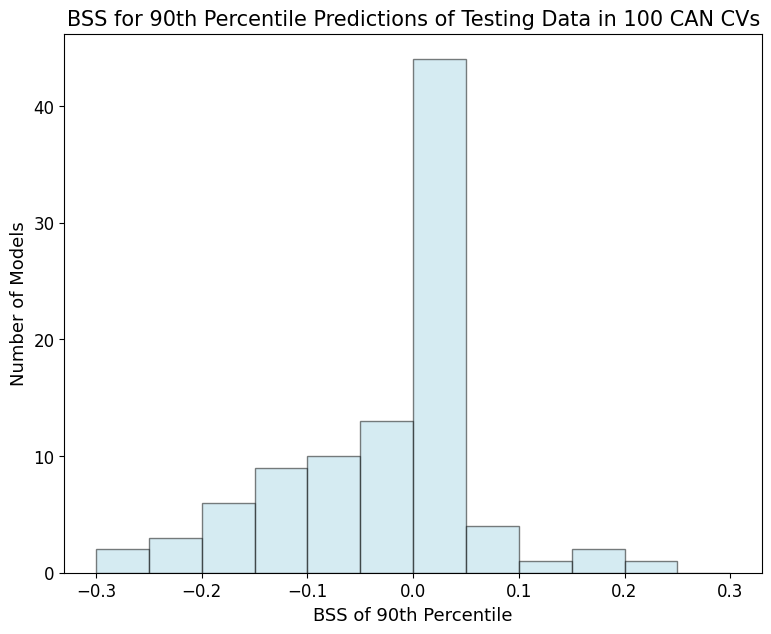

In [33]:
bins = np.linspace(-0.3, 0.3,13)
counts, edges, = np.histogram(BSS_90[:], bins=bins)

fig, (ax1) = plt.subplots(1,1, figsize=(9,7))

ax1.bar(edges[:-1], counts, width=np.diff(edges), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS of 90th Percentile',fontsize =13)
ax1.set_ylabel('Number of Models',fontsize =13)
plt.tick_params(labelsize = 12)
ax1.set_title('BSS for 90th Percentile Predictions of Testing Data in 100 CAN CVs',fontsize =15)
#plt.savefig("BSS90_eur14.png")

Text(0.525, 0.95, 'BSS of Predictions in Various Percentiles of Testing Data in 100 CAN CVs for Predicting +14 day European Temp Anomalies')

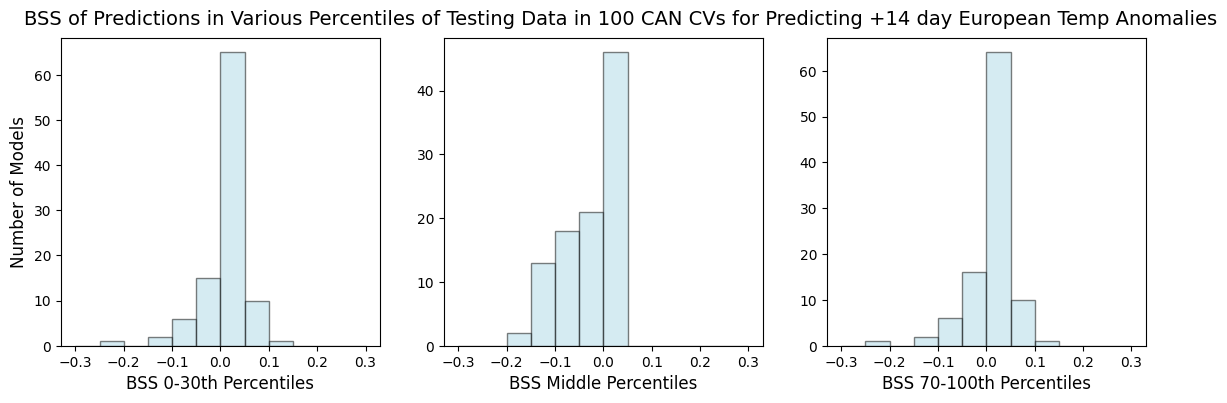

In [34]:
bins = np.linspace(-0.3, 0.3,13)
fs = 11

counts1, edges1, = np.histogram(BSS_30[:], bins=bins)
counts2, edges2, = np.histogram(BSS_avg[:], bins=bins)
counts3, edges3, = np.histogram(BSS_70[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS 0-30th Percentiles', fontsize=fs+1)
ax1.set_ylabel('Number of Models', fontsize=fs+1)

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax2.set_xlabel('BSS Middle Percentiles', fontsize=fs+1)
#ax2.set_ylabel('Number of Models', fontsize=fs+1)

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax3.set_xlabel('BSS 70-100th Percentiles', fontsize=fs+1)
#ax3.set_ylabel('Number of Models', fontsize=fs+1)

plt.suptitle('BSS of Predictions in Various Percentiles of Testing Data in 100 CAN CVs for Predicting +14 day European Temp Anomalies', fontsize=fs+3, x=0.525,y=0.95)
#plt.savefig("BSSpercentile_eur14.png")

Text(0.525, 0.95, 'BSS of Predictions Across All Datasets in 100 CAN CVs for Predicting +14 day European Temp Anomalies')

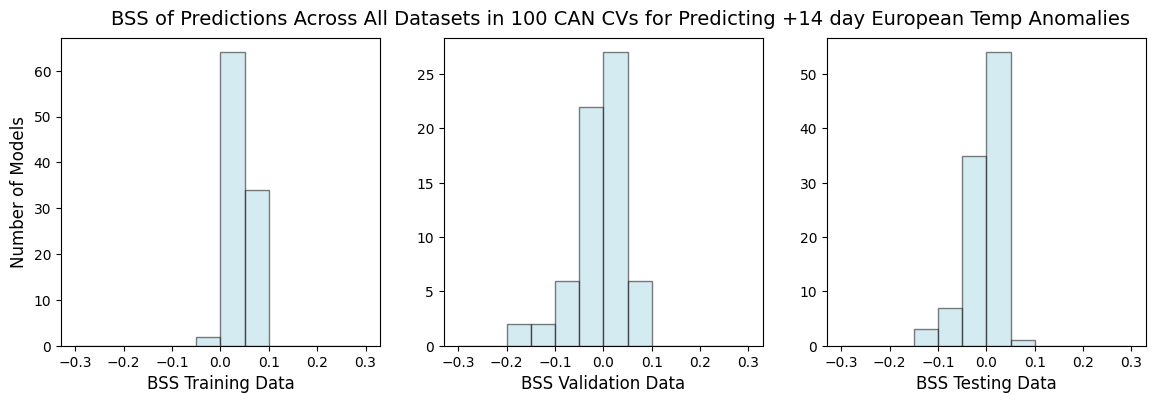

In [35]:
bins = np.linspace(-0.3, 0.3,13)
fs = 11

counts1, edges1, = np.histogram(BSS_train[:], bins=bins)
counts2, edges2, = np.histogram(BSS_val[:], bins=bins)
counts3, edges3, = np.histogram(BSS_test[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS Training Data', fontsize=fs+1)
ax1.set_ylabel('Number of Models', fontsize=fs+1)

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax2.set_xlabel('BSS Validation Data', fontsize=fs+1)
#ax2.set_ylabel('Number of Models', fontsize=fs+1)

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax3.set_xlabel('BSS Testing Data', fontsize=fs+1)
#ax3.set_ylabel('Number of Models', fontsize=fs+1)

plt.suptitle('BSS of Predictions Across All Datasets in 100 CAN CVs for Predicting +14 day European Temp Anomalies', fontsize=fs+3, x=0.525,y=0.95)
#plt.savefig("BSSdatasets_eur14.png")

In [36]:
len(p_train)

585800

In [37]:
p_test = np.array(p_test)
p_test = p_test.reshape(((len(p_test),3)))

p_train = np.array(p_train)
p_train = p_train.reshape(((len(p_train),3)))

p_val= np.array(p_val)
p_val = p_val.reshape(((len(p_val),3)))

p_mid= np.array(p_mid)
p_mid = p_mid.reshape(((len(p_mid),3)))

p_30= np.array(p_30)
p_30 = p_30.reshape(((len(p_30),3)))

p_70= np.array(p_70)
p_70 = p_70.reshape(((len(p_70),3)))

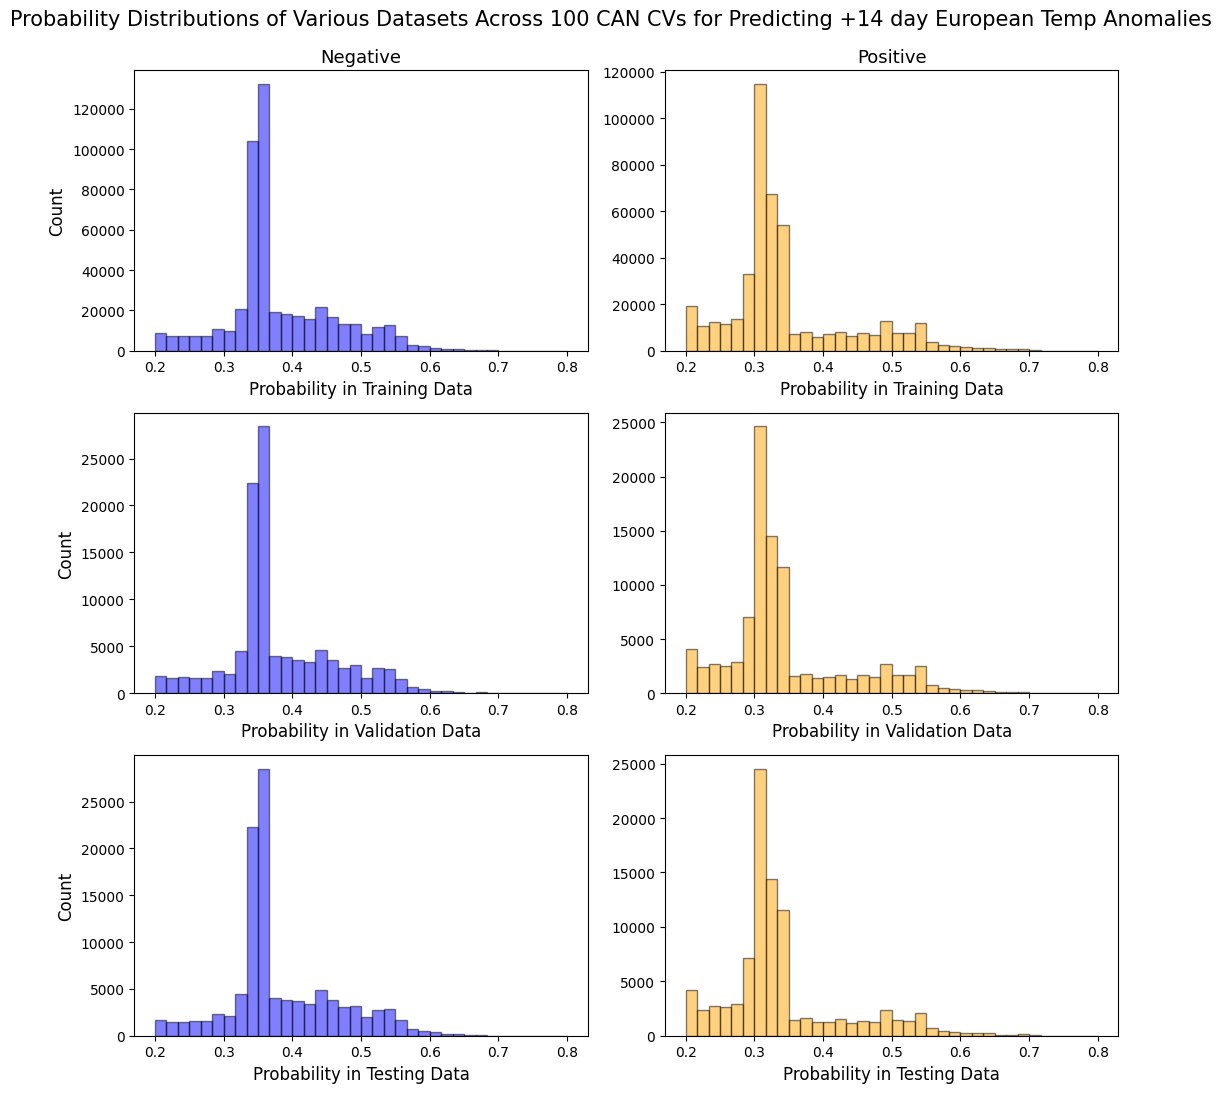

In [38]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_val[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_test[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in Training Data', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in Training Data', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Validation Data', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Validation Data', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in Testing Data', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in Testing Data', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions of Various Datasets Across 100 CAN CVs for Predicting +14 day European Temp Anomalies", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
#plt.savefig("probability_distrib_eur14.png")

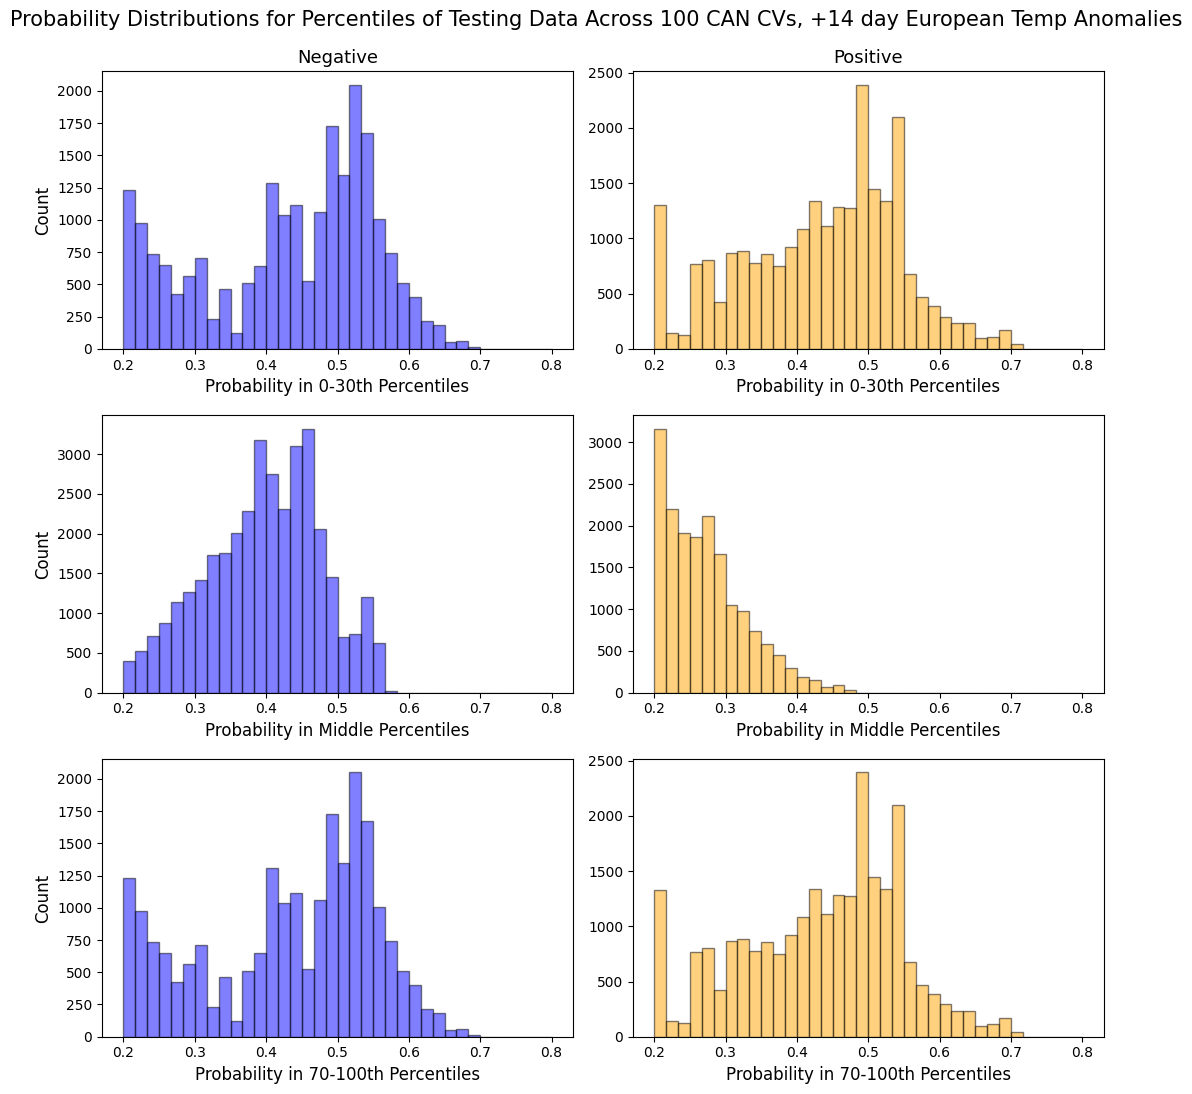

In [39]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_30[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_30[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_mid[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_mid[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_70[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_70[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in 0-30th Percentiles', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in 0-30th Percentiles', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Middle Percentiles', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Middle Percentiles', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in 70-100th Percentiles', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in 70-100th Percentiles', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions for Percentiles of Testing Data Across 100 CAN CVs, +14 day European Temp Anomalies", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
#plt.savefig("percentile_distrib_eur14.png")

### Model Curves. 

### Skill Score Distributions. 

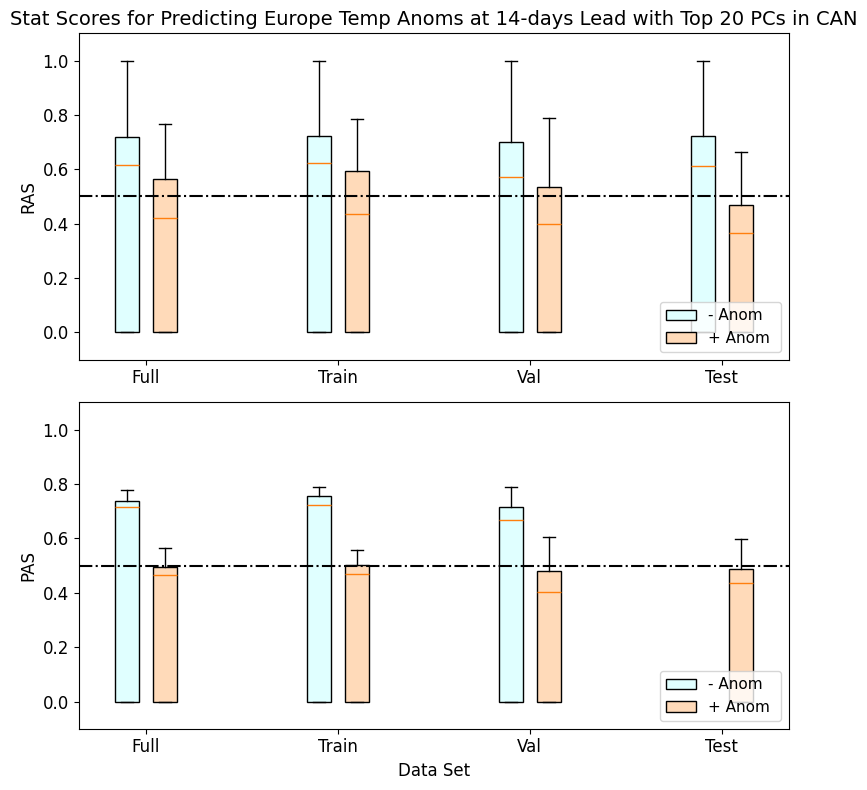

In [40]:
#plot
fig = plt.figure(figsize=(8,8))
font = 12
#loop through each member
ax2 = plt.subplot(2,1,1)
ax3 = plt.subplot(2,1,2)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax2.set_title("Stat Scores for Predicting Europe Temp Anoms at 14-days Lead with Top 20 PCs in CAN",fontsize = 14) 

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 11)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 11)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
#plt.savefig("EUR_StatScore_14.png", bbox_inches='tight',dpi =150)


### Percentile ACC Plots.

Text(0.5, 1.0, 'Testing Prediction Accuracy Across 100 CAN Models for +14 day Europe Temp Anomalies')

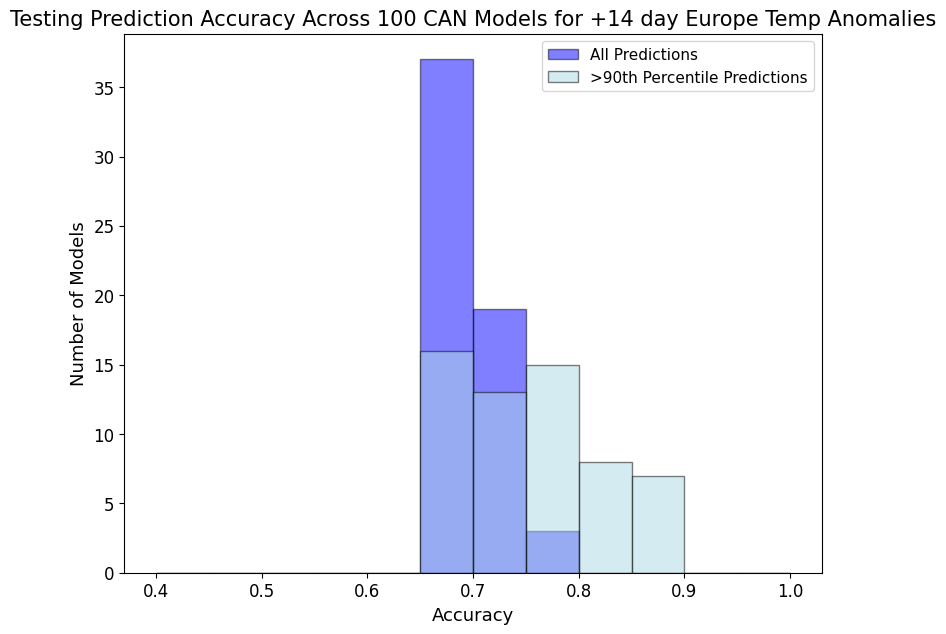

In [41]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
fig = plt.figure(figsize=(9,7))
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy', fontsize =13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Number of Models', fontsize =13)
plt.legend(fontsize = 11)
plt.title('Testing Prediction Accuracy Across 100 CAN Models for +14 day Europe Temp Anomalies', fontsize =15)
#plt.savefig("EUR14_ACCtesting.png")